<a href="https://colab.research.google.com/github/JaideepBalde/AI-powered-Dashboard/blob/main/StockForcastingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed

Epoch 1/30


116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 0.0114
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 7.7090e-04
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - loss: 7.4000e-04
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 5.7251e-04
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 5.5364e-04
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 6.1368e-04
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 5.9309e-04
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 4.3625e-04
Epoch 9/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 6.7736e-04
Epoch 10/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 4.5676e-04
Epoch 11/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 3.8946e-04
Epoch 12/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - loss: 4.9790e-04
Epoch 13/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 4.1959e-04
Epoch 14/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 3.8

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step

📈 Predicted Nifty 50 Close (5 Days Ahead): ₹25199.68

💡 Strategy Signal: Buy
Reason: MACD positive and Close > MA50, High volatility


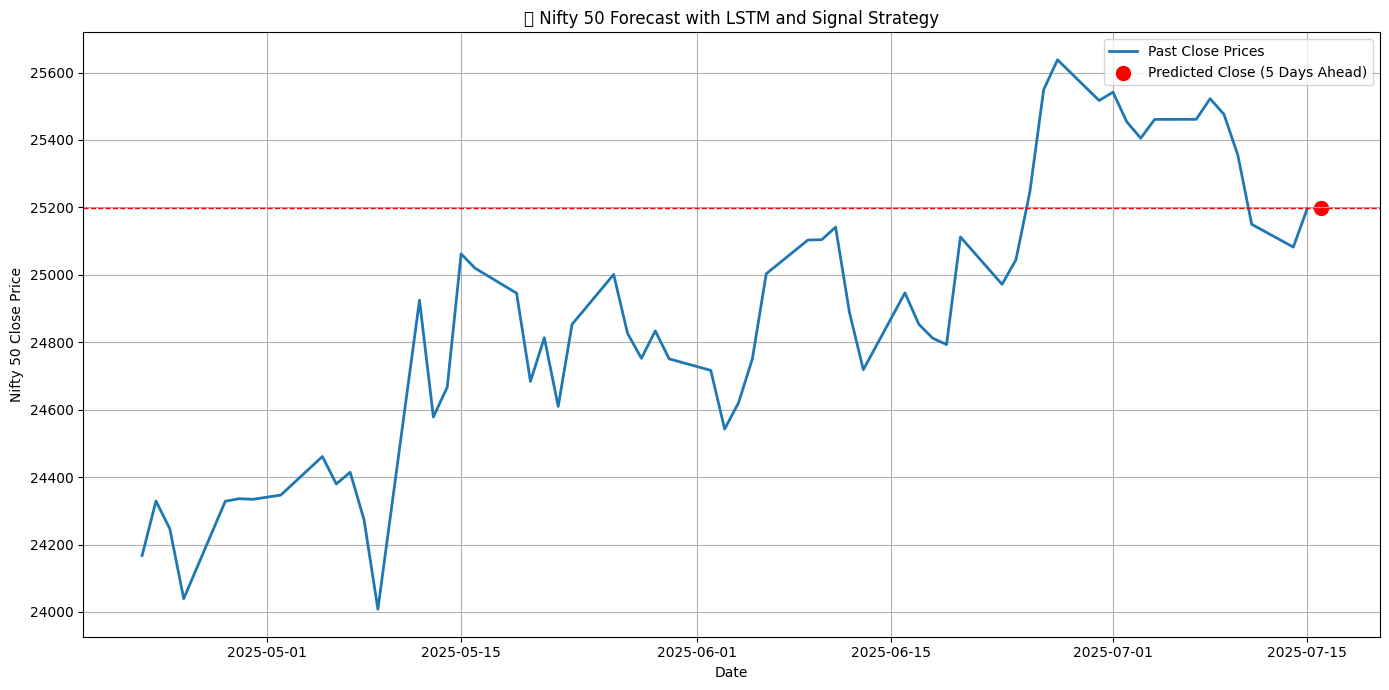

In [20]:
# ✅ SECTION 1: Install and Import Dependencies
!pip install yfinance ta --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
import ta
import joblib
import warnings
warnings.filterwarnings("ignore")

# ✅ SECTION 2: Fetch & Prepare Historical Nifty 50 Data
symbol = "^NSEI"
df = yf.download(symbol, start="2010-01-01", interval='1d')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# ✅ SECTION 3: Feature Engineering (Technical Indicators)
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
close_series = df['Close'].squeeze()  # Fix dimensionality for TA-Lib
df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
df['MACD'] = ta.trend.MACD(close=close_series).macd()
df['Volatility'] = close_series.rolling(window=10).std()
df['ATR'] = ta.volatility.AverageTrueRange(
    high=df['High'].squeeze(),
    low=df['Low'].squeeze(),
    close=close_series
).average_true_range()
df.dropna(inplace=True)


# ✅ SECTION 4: Data Preprocessing
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MA50', 'RSI', 'MACD', 'Volatility', 'ATR']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

X, y = [], []
time_step = 60
for i in range(time_step, len(scaled_data) - 5):
    X.append(scaled_data[i - time_step:i])
    y.append(scaled_data[i + 5][3])

X, y = np.array(X), np.array(y)
joblib.dump(scaler, 'nifty_scaler.save')
np.save('X_data.npy', X)
np.save('y_data.npy', y)

# ✅ SECTION 5: Model Training

def train_lstm_model(X, y):
    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=30, batch_size=32, verbose=1)
    model.save('nifty_lstm_model.h5')
    return model

try:
    model = load_model('nifty_lstm_model.h5')
except:
    model = train_lstm_model(X, y)

# ✅ SECTION 6: Forecasting Future Price
last_60 = scaled_data[-60:]
future_input = np.array([last_60])
future_pred_scaled = model.predict(future_input)

pad_before = np.zeros((1, features.index('Close')))
pad_after = np.zeros((1, len(features) - features.index('Close') - 1))
combined = np.concatenate((pad_before, future_pred_scaled.reshape(1, 1), pad_after), axis=1)
future_pred = scaler.inverse_transform(combined)[0][features.index('Close')]

print(f"\n\U0001f4c8 Predicted Nifty 50 Close (5 Days Ahead): ₹{future_pred:.2f}\n")

# ✅ SECTION 7: Strategy-Based Signal Generation

def generate_signals(df):
    latest = df.iloc[-1]
    signal = "Hold"
    reason = []

    # Ensure scalars (not Series)
    rsi = float(latest['RSI'])
    macd = float(latest['MACD'])
    close = float(latest['Close'])
    ma50 = float(latest['MA50'])
    volatility = float(latest['Volatility'])
    avg_volatility = float(df['Volatility'].mean())

    # Rules
    if rsi < 30:
        signal = "Buy"
        reason.append("RSI oversold (<30)")
    elif rsi > 70:
        signal = "Sell"
        reason.append("RSI overbought (>70)")

    if macd > 0 and close > ma50:
        signal = "Buy"
        reason.append("MACD positive and Close > MA50")

    if volatility > avg_volatility:
        reason.append("High volatility")

    return signal, reason



signal, reason = generate_signals(df)
print(f"\U0001f4a1 Strategy Signal: {signal}")
print("Reason:", ", ".join(reason))

# ✅ SECTION 8: Visualization
past_close = df['Close'].iloc[-60:].values.tolist()
past_dates = df.index[-60:].tolist()
future_date = pd.date_range(start=df.index[-1], periods=6, freq='B')[1]

plt.figure(figsize=(14, 7))
plt.plot(past_dates, past_close, label='Past Close Prices', linewidth=2)
plt.scatter(future_date, future_pred, color='red', label='Predicted Close (5 Days Ahead)', s=100)
plt.axhline(y=future_pred, color='red', linestyle='--', linewidth=1)
plt.xlabel("Date")
plt.ylabel("Nifty 50 Close Price")
plt.title("\U0001f4ca Nifty 50 Forecast with LSTM and Signal Strategy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
